In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')


path = '/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/data/preprocessedData'

In [2]:
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')
X_val = pd.read_csv(path + '/X_val.csv')
y_val = pd.read_csv(path + '/y_val.csv')
test = pd.read_csv(path + '/test.csv')

In [3]:
#Reshape
image_col = 28
image_row = 28
X_train1 = X_train.values.reshape(X_train.shape[0],image_col,image_row,1)
X_val1 = X_val.values.reshape(X_val.shape[0],image_col,image_row,1)
test1 = test.values.reshape(test.shape[0],image_col,image_row,1)
X_train1.shape,X_val1.shape,test1.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (28000, 28, 28, 1))

In [4]:
# Label Encoding (# convert label to one-hot-encoding)
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y_train1 = to_categorical(y_train, num_classes = 10)
y_val1 = to_categorical(y_val, num_classes = 10)
y_train1.shape,y_val1.shape

((37800, 10), (4200, 10))

**Inception 10**

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import Add, Activation,GlobalAveragePooling2D,Flatten

class ConvBnRelu(Model):
  def __init__(self,filter_num, kernel_size=(3,3),strides=1, padding='same'):
    super(ConvBnRelu, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, strides, padding)
    self.bn = BatchNormalization()
    self.relu = Activation('relu')

  def call(self, x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.relu(out)
    return out

In [7]:
class InceptionBlock(Model):
  def __init__(self,filter_num,strides=1):
    super(InceptionBlock, self).__init__()
    self.conv1 = ConvBnRelu(filter_num, kernel_size=(1,1), strides=strides)
    self.conv2_1 = ConvBnRelu(filter_num, kernel_size=(1,1), strides=strides)
    self.conv2_2 = ConvBnRelu(filter_num, kernel_size=(3,3))
    self.conv3_1 = ConvBnRelu(filter_num, kernel_size=(1,1), strides=strides)
    self.conv3_2 = ConvBnRelu(filter_num, kernel_size=(5,5))
    self.conv4_1 = MaxPool2D(pool_size=(3,3), strides=1, padding='same')
    self.conv4_2 = ConvBnRelu(filter_num, kernel_size=(1,1), strides=strides)

  def call(self, x):
    out1 = self.conv1(x)
    out2 = self.conv2_1(x)
    out2 = self.conv2_2(out2)
    out3 = self.conv3_1(x)
    out3 = self.conv3_2(out3)
    out4 = self.conv4_1(x)
    out4 = self.conv4_2(out4)

    #concat 4 outputs
    out = tf.concat([out1,out2,out3,out4],axis=3)
    return out

In [10]:
class Inception10(Model):

    def __init__(self):
        super(Inception10, self).__init__()
        self.conv1 =  ConvBnRelu(filter_num=16)

        self.incepblk1 = InceptionBlock(filter_num=16,strides=2)
        self.incepblk2 = InceptionBlock(filter_num=16)
        self.incepblk3 = InceptionBlock(filter_num=32,strides=2)
        self.incepblk4 = InceptionBlock(filter_num=32)

        self.avgpool = GlobalAveragePooling2D()
        self.dense = Dense(10, activation='softmax')

    def call(self, x):
        out = self.conv1(x)
        out = self.incepblk1(out)
        out = self.incepblk2(out)
        out = self.incepblk3(out)
        out = self.incepblk4(out)

        out = self.avgpool(out)
        out = self.dense(out)

        return out


In [11]:
lr = 0.0001
batch_size = 32
EPOCHS = 50

# Build your model here
model = Inception10()
optimizer = tf.keras.optimizers.Adam(lr)

In [12]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [13]:
#Checkpoint
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/inception10/inception10.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True)      

In [14]:
history = model.fit(X_train1, y_train1, batch_size=32, epochs=EPOCHS, validation_data=(X_val1, y_val1),callbacks=[cp_callback])

Epoch 1/50
1182/1182 [==============================] - ETA: 0s - loss: 0.8194 - categorical_accuracy: 0.7951
Epoch 00001: val_loss improved from inf to 0.23643, saving model to /content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/inception10/inception10.ckpt
1182/1182 [==============================] - 14s 12ms/step - loss: 0.8194 - categorical_accuracy: 0.7951 - val_loss: 0.2364 - val_categorical_accuracy: 0.9490
Epoch 2/50
1182/1182 [==============================] - ETA: 0s - loss: 0.1716 - categorical_accuracy: 0.9626
Epoch 00002: val_loss improved from 0.23643 to 0.11538, saving model to /content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/inception10/inception10.ckpt
1182/1182 [==============================] - 13s 11ms/step - loss: 0.1716 - categorical_accuracy: 0.9626 - val_loss: 0.1154 - val_categorical_accuracy: 0.9729
Epoch 3/50
1182/1182 [==============================] - ETA: 0s - loss: 0.0961 - categorical_accuracy: 0.9770
Epoch 00003: val_l

In [15]:
model.summary()

Model: "inception10_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu_25 (ConvBnRelu) multiple                  224       
_________________________________________________________________
inception_block_4 (Inception multiple                  10208     
_________________________________________________________________
inception_block_5 (Inception multiple                  13280     
_________________________________________________________________
inception_block_6 (Inception multiple                  43968     
_________________________________________________________________
inception_block_7 (Inception multiple                  52160     
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                

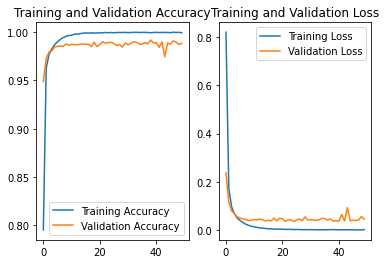

In [16]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
predictions = model.predict(test1, verbose=0)
#print(predictions)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": np.argmax(predictions,axis=1)})
submissions.to_csv("inception10.csv", index=False, header=True)

In [18]:
print(np.argmax(predictions,axis=1)[:50])

[2 0 9 0 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7]


In [ ]:
#load weights from checkpoint
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Digit Recognizer/checkpoints/inception10/inception10.ckpt'
model.load_weights(checkpoint_path)

In [ ]:
predictions = model.predict(test1, verbose=0)
#print(predictions)

print(np.argmax(predictions,axis=1)[:50])

[2 0 9 0 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7]


In [27]:
 !kaggle competitions submit -c digit-recognizer -f inception10.csv -m "inception10 result"

100% 208k/208k [00:00<00:00, 320kB/s]
Successfully submitted to Digit Recognizer